In [20]:
import numpy as np
import random
import itertools
import scipy.misc
import matplotlib.pyplot as plt
import random
import networkx as nx


# hyper parameters
K = 25
# T_max = 9
r_endpoint  = 2
r_edgeserver = 5 
time_slot_duration = 50 #seconds
discount_factor = 0.1
learning_rate = 0.001
epsilon = 0.99



class Env():
    def __init__(self,endpoints, edgeservers,):
        self.endpoints = endpoints
        self.edgeservers = edgeservers
        self.G = nx.Graph()
        self.edges = []
        self.nodes = np.zeros(1  + edgeservers + endpoints)  #this is the processing power
        self.base_index = self.edgeservers + 1
        # self.r_endpoints = 
        self.resources = [np.zeros(1000)]+[np.zeros(r_edgeserver) for _ in range(self.edgeservers)] + [np.zeros(r_endpoint) for _ in range(self.endpoints)]
        self.n_actions = 1 + self.edgeservers + 1
        self.workloads = []
        


    def configure_network(self):

        # declaring the edges between core cloud and the edgeserves
        for j in range(1, self.edgeservers + 1):
          # self.edges.append((0,j ))
          self.G.add_edge(j,0)
          self.G[j][0]['weight'] = random.uniform(400,500)
          

        # declaring the edges between edgeservers
        for i in range(1, self.edgeservers):
          self.G.add_edge(i,i+1)
          self.G.add_edge(i+1,i)
          self.G[i][i+1]['weight'] = random.uniform(250,300)

        # declaring the edges between edgeservers and endpoints
        for i,j in zip(range(1 + self.edgeservers ,self.endpoints + 1 + self.edgeservers), np.resize(np.arange(1,self.edgeservers + 1), self.endpoints)):
          self.G.add_edge(i,j)
          self.G[i][j]['weight'] = random.uniform(180,250)

        # print(self.G[0])

        # declaring the processing power 
        self.nodes[0] = random.uniform(5000,7000) # Core cloud processing power
        for i in range(1,self.base_index):
          self.nodes[i] = random.uniform(500,2500) # Edge serverse processing power
        for i in range(self.base_index, len(self.nodes)):
          self.nodes[i] = random.uniform(50,300) # Endpoints porcessing power
        
    

    def generate_task(self):
        # generating workload values (fixed workloads) #first value is the offload and the second value is the emergency level
        self.workloads = [(i, random.uniform(1e3 * 3.0, 1e4 * 3.0), np.random.choice([0,1], p=[0.7, 0.3]))  for i in range(self.endpoints)] 
        # return self.workloads

    def initalize_Qtable(self):
        self.Qtable = np.zeros((self.endpoints, 1 + self.edgeservers + 1))
        # print(self.Qtable)

    def reward(self, node1, node2, W): # according to task formulation 
      latency = 0
      if node2 == self.n_actions - 1 :
        node2 = node1
      path = nx.shortest_path(self.G, source = node1,  target = node2)
      for i in range(len(path) - 1):
        B = self.G[i][i+1]['weight']
        latency += W / (B * self.network_gain())
      latency += W / self.nodes[int(node2)] 
      return latency
    

    def policy_action(self):
      self.actions = np.zeros(self.endpoints)
      for index, Q_vales in enumerate(self.Qtable):

        self.actions[index] = int(np.argmin(Q_vales))
      # print(self.actions)
      # return self.actions

    def random_action(self):
      self.actions =[random.randint(0,1 + self.edgeservers) for _ in range(self.endpoints)]
      # return self.actions

    def update_Qtable(self):
      """The algorithm should placed here"""
       # we are take into account the priority
      for u in range(self.endpoints):
          # print(self.actions[u])
          self.Qtable[u][int(self.actions[u])] = (1-learning_rate) * self.Qtable[u][int(self.actions[u])] + learning_rate * (self.cost[u] + discount_factor * np.max(self.Qtable[u]))

    def network_gain(self):
      return np.random.choice([0.5,0.25], p = [0.5,0.5])
    
    def update_resource(self):
      for r in self.resources:
        r -= 50
        for i in range(len(r)):

          if r[i] < 0:
            r[i] = 0
      # return resource
    
    def capacity_check(self, resource):
      c = False
      for elem in resource:
        if elem == 0:
          c = True
          return c
    def allocate_task(self, resource, W, P):
      for i, slot in enumerate(resource):
        if slot == 0:
          resource[i] = W / P
          return resource
          

    def step(self):
      self.cost = np.zeros(self.endpoints)
      for u, workload,_ in sorted(self.workloads, key = lambda X: X[-1]):
        
        if self.actions[u] == self.n_actions - 1:
           processor = self.resources[int(self.base_index + u)]
           if self.capacity_check(processor):
             self.resources[self.base_index + u] = self.allocate_task(processor, workload, self.nodes[self.base_index + u])
             self.cost[u] = self.reward(u, self.actions[u], workload)
           else: 
             self.cost[u] = self.reward(u, self.actions[0], workload)

        else:
          # print(self.actions[u])
  
          processor = self.resources[int(self.actions[u])]
          # print(self.actions[u])
          
          if self.capacity_check(processor):
             self.resources[int(self.actions[u])] = self.allocate_task(processor, workload, self.nodes[int(self.actions[u])])
             self.cost[u] = self.reward(u,self.actions[u], workload)
          else:
            self.cost[u] = self.reward(u, self.actions[0], workload)

    def clean_resources(self):
        self.resources = [np.zeros(1000)]+[np.zeros(r_edgeserver) for _ in range(self.edgeservers)] + [np.zeros(r_endpoint) for _ in range(self.endpoints)]



In [23]:
from posixpath import expandvars
def Q_learning(plot = False):
  env = Env(10,3)
  env.configure_network()
  # env.generate_task()
  env.initalize_Qtable()
  cost = []
  for episode in range(1000):
    for t in range(K):
      c = 0
      if random.random() > epsilon:
        env.random_action()
      else:
        env.policy_action()
      env.generate_task()
      env.step()
      c += sum(env.cost)/150
      env.update_Qtable()
      env.update_resource()
    cost.append(c)

  if plot:
      plt.plot(cost, color = 'b')
      plt.xlabel('Iterations')
      plt.ylabel('Average cost')
      plt.plot(cost)
  return env



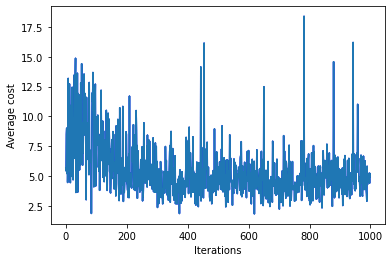

In [24]:
QL = Q_learning(True)


In [7]:
QL.Qtable

array([[  4.14806814,   9.02158906,   6.97292186,   8.27072025,
          4.10421013],
       [ 32.16255181,  30.66129504,  32.37481526,  38.99957914,
         31.04065294],
       [ 13.04609426,  12.64338034,   9.09503274,  12.563157  ,
          9.22779184],
       [ 16.17136948,  22.07178434,  16.80707181,  13.20463588,
         13.32492745],
       [ 99.50402171,  94.92463592,  98.14711027, 102.70657351,
         91.58943739],
       [122.39626886, 122.477994  , 122.3063873 , 122.35258237,
        113.7972914 ],
       [128.70756493, 133.42496088, 128.02144646, 127.49416735,
        128.00887033],
       [ 96.95788048,  89.4255044 ,  92.45167807,  97.09308563,
         86.62562154],
       [123.80275775, 122.61106639, 120.76344523, 121.7728668 ,
        109.51747445],
       [131.20080516, 134.29617902, 133.4912941 , 127.00698766,
        130.29957496]])